## Neural network

Basic neural network using pytorch

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
from math import pi, cos, sin

import torch
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
torch.set_printoptions(edgeitems=2, linewidth=75)

In [3]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_x, train_y, val_x, val_y):
    for epoch in range(1, n_epochs + 1):
        train_p_y = model(train_x)
        loss_train = loss_fn(train_p_y, train_y)

        val_p_y = model(val_x)
        loss_val = loss_fn(val_p_y, val_y)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

## Experimental Protocols

In [62]:
def plot_samples(xs, ys):
    fig = plt.figure(figsize=[6,6])
    class_0 = [x for x, y in zip(list(xs), list(ys)) if y[0] == 1.0]
    class_1 = [x for x, y in zip(list(xs), list(ys)) if y[1] == 1.0]
    plt.scatter([x[0] for x in class_0], [x[1] for x in class_0], color='b', alpha=0.5)
    plt.scatter([x[0] for x in class_1], [x[1] for x in class_1], color='r', alpha=0.5)
    plt.show()

def plot_classifications(model, xs, ys, limits):
    fig = plt.figure(figsize=[6,6])

    self_fit = model(xs)

    def filter_xs(xs, ys, selected_class, correct):
        return [
            x for x, y, s in zip(list(xs), list(ys), list(self_fit))
            if torch.all(torch.eq(selected_class, y)) and (
                (correct and torch.argmax(y) == torch.argmax(s)) or
                (not correct and torch.argmax(y) != torch.argmax(s))
            )           
        ]

    for selected_class, correct, color, alpha in [
        (torch.tensor([1.0, 0.0]), True, 'b', 0.1),
        (torch.tensor([0.0, 1.0]), True, 'r', 0.1),
        (torch.tensor([1.0, 0.0]), False, 'b', 1.0),
        (torch.tensor([0.0, 1.0]), False, 'r', 1.0),
    ]:
        filtered_xs = filter_xs(xs, ys, selected_class, correct)
        plt.scatter([x[0] for x in filtered_xs], [x[1] for x in filtered_xs], color=color, alpha=alpha)
    plt.xlim(limits[0])
    plt.ylim(limits[1])
    plt.title('Classifications (errors in bold)')
    plt.show()

def plot_2d_heatmap(model, dimension_limits):
    bins = 100
    image = torch.zeros(bins, bins)
    linspaces = [torch.linspace(d[0], d[1], bins) for d in dimension_limits]
    for i in range(bins):
        for j in range(bins):
            d1 = linspaces[0][j]
            d2 = linspaces[1][i]
            x = torch.tensor([[d1, d2]])
            y = model(x).detach()
            image[i, j] = y[0,1] - y[0,0]
    fig = plt.figure(figsize=[6,6])
    plt.imshow(torch.flip(image, [1]), cmap='coolwarm', extent=(dimension_limits[0] + dimension_limits[1]))
    plt.title('Classification Heatmap')
    plt.show()

## Diagonals problem

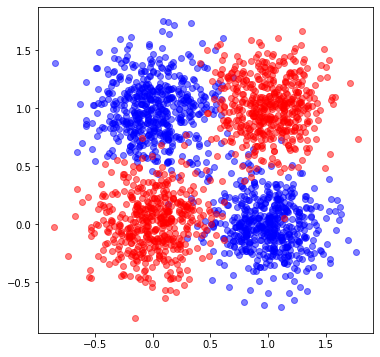

In [63]:
def sample(n):
    source_xs = [[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]]
    source_ys = [[0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0]]
    source_inds = [random.randint(0,len(source_xs) - 1) for i in range(n)]
    xs = torch.tensor([source_xs[i] for i in source_inds]) + torch.randn(n,2) * 0.25
    ys = torch.tensor([source_ys[i] for i in source_inds])
    return xs, ys

dimension_limits = [[-1, 2], [-1, 2]]

xs, ys = sample(2000)
val_xs, val_ys = sample(200)
plot_samples(xs, ys)

In [64]:
model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(2, 6)),
    ('hidden_activation', nn.LeakyReLU()),
    ('output_linear', nn.Linear(6, 2))
]))

optimizer = optim.Adam(model.parameters(), lr=5e-3)

training_loop(
    n_epochs = 10000, 
    optimizer = optimizer,
    model = model,
    loss_fn = nn.MSELoss(),
    train_x = xs,
    train_y = ys, 
    val_x = val_xs,
    val_y = val_ys
)

Epoch 1, Training loss 0.3961, Validation loss 0.4003
Epoch 1000, Training loss 0.0449, Validation loss 0.0593
Epoch 2000, Training loss 0.0399, Validation loss 0.0613
Epoch 3000, Training loss 0.0394, Validation loss 0.0632
Epoch 4000, Training loss 0.0393, Validation loss 0.0640
Epoch 5000, Training loss 0.0392, Validation loss 0.0646
Epoch 6000, Training loss 0.0391, Validation loss 0.0641
Epoch 7000, Training loss 0.0389, Validation loss 0.0647
Epoch 8000, Training loss 0.0389, Validation loss 0.0652
Epoch 9000, Training loss 0.0388, Validation loss 0.0655
Epoch 10000, Training loss 0.0387, Validation loss 0.0653


In [65]:
model.eval()

Sequential(
  (hidden_linear): Linear(in_features=2, out_features=6, bias=True)
  (hidden_activation): LeakyReLU(negative_slope=0.01)
  (output_linear): Linear(in_features=6, out_features=2, bias=True)
)

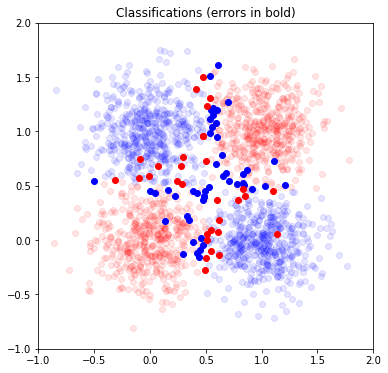

In [66]:
plot_classifications(model, xs, ys, dimension_limits)

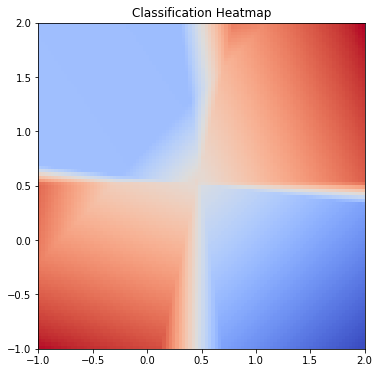

In [67]:
plot_2d_heatmap(model, dimension_limits)

## Donut problem

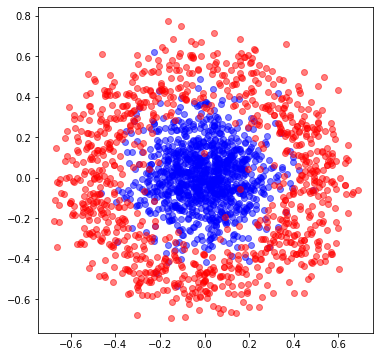

In [68]:
def sample(n):
    class0_func = lambda: torch.randn(1,2) * 0.15
    def class1_func():
        t = random.random() * 2.0 * pi
        r = 0.5
        return torch.tensor([r * sin(t), r * cos(t)]) + torch.randn(1,2) * 0.1
    
    xs = []
    ys = []
    for i in range(n):
        if random.randint(0,1) == 0:
            xs.extend(class0_func())
            ys.append([1.0, 0.0])
        else:
            xs.extend(class1_func())
            ys.append([0.0, 1.0])
    return torch.stack(xs), torch.tensor(ys)

dimension_limits = [[-0.75, 0.75], [-0.75, 0.75]]

xs, ys = sample(2000)
val_xs, val_ys = sample(200)
plot_samples(xs, ys)

In [95]:
model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(2, 36)),
    ('hidden_activation', nn.LeakyReLU()),
    ('output_linear', nn.Linear(36, 2))
]))

optimizer = optim.Adam(model.parameters(), lr=5e-3)

training_loop(
    n_epochs = 10000, 
    optimizer = optimizer,
    model = model,
    loss_fn = nn.MSELoss(),
    train_x = xs,
    train_y = ys, 
    val_x = val_xs,
    val_y = val_ys
)

Epoch 1, Training loss 0.6995, Validation loss 0.6991
Epoch 1000, Training loss 0.0498, Validation loss 0.0506
Epoch 2000, Training loss 0.0460, Validation loss 0.0483
Epoch 3000, Training loss 0.0445, Validation loss 0.0461
Epoch 4000, Training loss 0.0443, Validation loss 0.0462
Epoch 5000, Training loss 0.0441, Validation loss 0.0462
Epoch 6000, Training loss 0.0440, Validation loss 0.0463
Epoch 7000, Training loss 0.0439, Validation loss 0.0464
Epoch 8000, Training loss 0.0439, Validation loss 0.0464
Epoch 9000, Training loss 0.0438, Validation loss 0.0464
Epoch 10000, Training loss 0.0438, Validation loss 0.0464


In [96]:
model.eval()

Sequential(
  (hidden_linear): Linear(in_features=2, out_features=36, bias=True)
  (hidden_activation): LeakyReLU(negative_slope=0.01)
  (output_linear): Linear(in_features=36, out_features=2, bias=True)
)

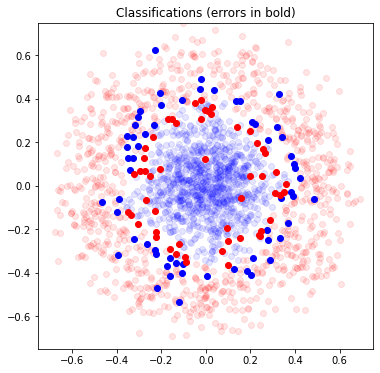

In [97]:
plot_classifications(model, xs, ys, dimension_limits)

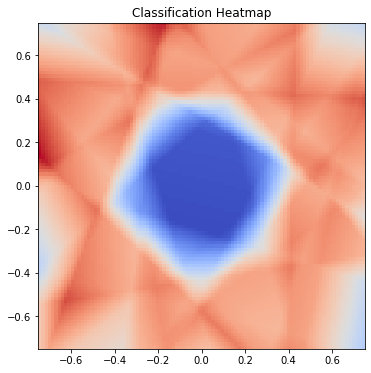

In [98]:
plot_2d_heatmap(model, dimension_limits)